In [2]:
import pandas as pd
import numpy as np
import monai
from glob import glob
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from met_brewer import met_brew
import scikit_posthocs as sp

 missing cuda symbols while dynamic loading
 cuFile initialization failed


## Merge metadata

In [3]:
amos = pd.read_csv("/data_analysis/amos/amos_metadata_def.csv")
totalseg = pd.read_csv("/data_analysis/totalseg/totalseg_metadata_def.csv")

In [27]:
def nnunet_dice(mask_pred: np.ndarray, mask_ref: np.ndarray):
    dice_scores = []
    for organ_class in range(1, 13):
        gt = (mask_ref == organ_class)
        pred = (mask_pred == organ_class)
        use_mask = np.ones_like(gt, dtype=bool)
        
        tp = np.sum((gt & pred) & use_mask)
        fp = np.sum(((~gt) & pred) & use_mask)
        fn = np.sum((gt & (~pred)) & use_mask)
        
        if tp + fp + fn == 0:
            dice_scores.append(np.nan)
        else:
            dice_scores.append(2 * tp / (2 * tp + fp + fn))
    
    return dice_scores

In [29]:
meta = []

for _, row in tqdm(amos.iterrows()):
    id = str(row['amos_id'])
    id = 'amos_'+'0'*(4 - len(id))+id
    sex = str(row["Patient's Sex"]).lower()
    age = int(row["Patient's Age"][:-1])
    manufacturer = str(row['Manufacturer']).lower()

    paths = sorted([p for p in glob(f"/nnUNet/inference/fold_*/*/{id}.nii.gz")])

    pred = monai.transforms.LoadImage(ensure_channel_first=True)(paths[1])
    gt = monai.transforms.LoadImage(ensure_channel_first=True)(paths[0])

    dice = nnunet_dice(pred, gt)

    results = [id, sex, age, manufacturer]

    for dice_organ in dice:
        results.append(dice_organ)
    
    results.append(np.nanmean(dice))
    
    meta.append(results)

for _, row in tqdm(totalseg.iterrows()):
    id = str(row['image_id'])
    sex = str(row["gender"]).lower()
    age = int(row["age"])
    manufacturer = str(row['manufacturer']).lower()

    paths = sorted([p for p in glob(f"/nnUNet/inference/fold_*/*/{id}.nii.gz")])

    pred = monai.transforms.LoadImage(ensure_channel_first=True)(paths[1])
    gt = monai.transforms.LoadImage(ensure_channel_first=True)(paths[0])

    dice = nnunet_dice(pred, gt)

    results = [id, sex, age, manufacturer]

    for dice_organ in dice:
        results.append(dice_organ)
    
    results.append(np.nanmean(dice))
    
    meta.append(results)

272it [32:34,  7.19s/it]
378it [11:47,  1.87s/it]


In [31]:
organs = [
    "Spleen",
    "Right Kidney",
    "Left Kidney",
    "Gallbladder",
    "Esophagus",
    "Liver",
    "Stomach",
    "Aorta",
    "Inferior Vena Cava",
    "Pancreas",
    "Right Adrenal Gland",
    "Left Adrenal Gland",
    "mean dice"
]

columns=['id', 'sex', 'age', 'manufacturer']

for organ in organs:
    columns.append(organ.lower())

In [32]:
pd.DataFrame(meta, columns=columns).to_csv("/data_analysis/merged_metadata_def.csv", index=False)

## Statistical Analysis

In [5]:
data = pd.read_csv("/data_analysis/nnunet_merged_metadata_def.csv")

### Sex

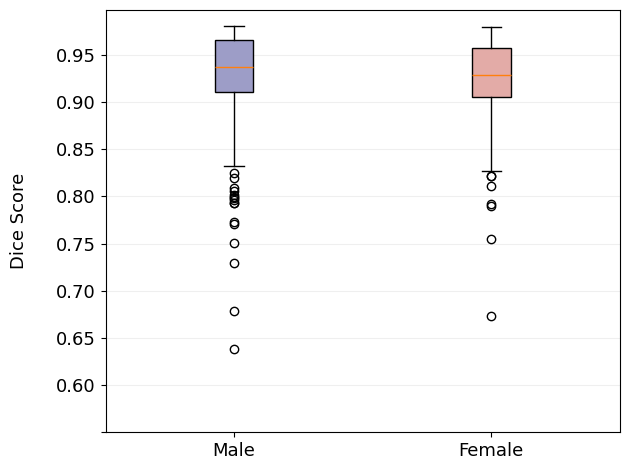

In [31]:
fontsize = 13

fig, ax = plt.subplots()

colors = met_brew(name="Cassatt1", n=2, brew_type="colorblind")

bplot = plt.boxplot([data.query("sex == 'm'")['mean dice'], data.query("sex == 'f'")['mean dice']], patch_artist=True)
plt.xticks([1, 2], ['Male', 'Female'], fontsize=fontsize)
plt.ylabel('Dice Score', fontsize=fontsize, labelpad=20)
plt.grid(alpha=0.2, axis='y')
plt.yticks(np.arange(0.55, 1, 0.05), ['', '0.60', '0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95'], fontsize=fontsize)

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[c-1])

plt.tight_layout()

plt.show()

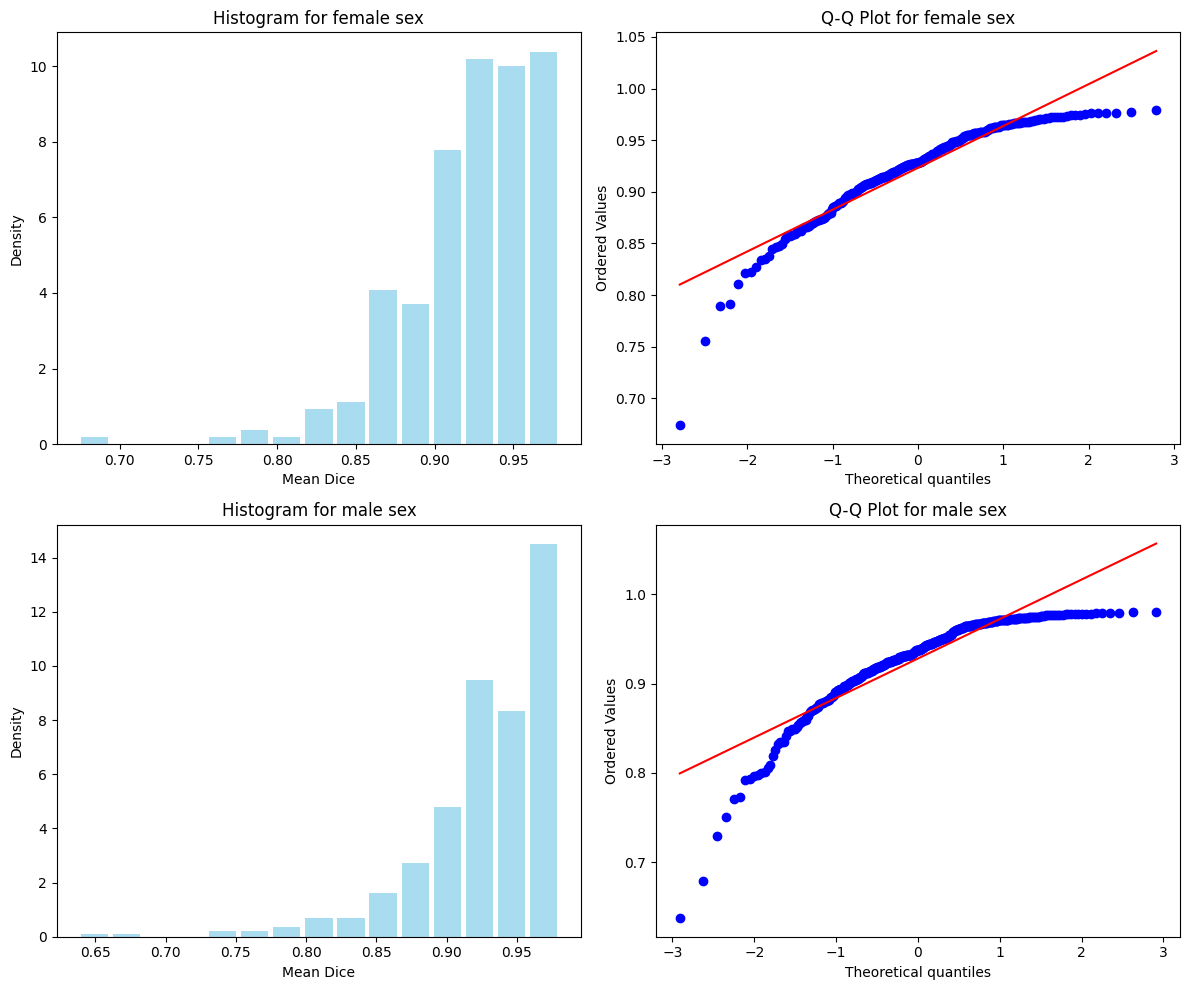

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i, sex in enumerate(['f', 'm']):
    title_name = 0
    if sex == 'f': title_name = 'female'
    else: title_name = 'male'
    sex_data = data[data['sex'] == sex]['mean dice']
    # Histogram
    axes[i, 0].hist(sex_data, bins=15, color='skyblue', alpha=0.7, rwidth=0.85, density=True)
    axes[i, 0].set_title(f'Histogram for {title_name} sex')
    axes[i, 0].set_xlabel('Mean Dice')
    axes[i, 0].set_ylabel('Density')

    # Q-Q plot
    stats.probplot(sex_data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot for {title_name} sex')
    
plt.tight_layout()

In [63]:
female_data = data[data['sex'] == 'f']['mean dice']
male_data = data[data['sex'] == 'm']['mean dice']

In [64]:
print(stats.shapiro(female_data))
print(stats.shapiro(male_data))

ShapiroResult(statistic=0.8911162396995945, pvalue=7.209928004065679e-13)
ShapiroResult(statistic=0.8346272563472608, pvalue=1.3354052345805446e-19)


The data is not normally distributed, as demonstrated by both the Shapiro-Wilk test and the histogram, so we will use the Mann-Whitney U rank test 

In [65]:
stats.mannwhitneyu(female_data, male_data)

MannwhitneyuResult(statistic=44996.0, pvalue=0.012210544709171963)

There is a statistically significant difference in both sex groups with a reasonable degree of confidence. This difference is significant at the 5% level, meaning there's about 0.86% chance that the difference observed is due to random variation alone.

### Age

In [28]:
data['age_bin'] = pd.cut(data['age'], bins=[10, 40, 60, 80, 101], right=False, labels=['10-39', '40-59', '60-79', '80-99'])

age_grouped = data.groupby('age_bin').agg({
    'mean dice': ['mean', 'std', 'count']
}).reset_index()

age_grouped.columns = ['Age Bin', 'Mean Dice', 'STD Dice', 'Count']

groups = [data['mean dice'][data['age_bin'] == bin] for bin in age_grouped['Age Bin']]

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,Age Bin,Mean Dice,STD Dice,Count
0,10-39,0.918621,0.037244,90
1,40-59,0.922573,0.047708,241
2,60-79,0.931291,0.044723,269
3,80-99,0.928076,0.055321,50


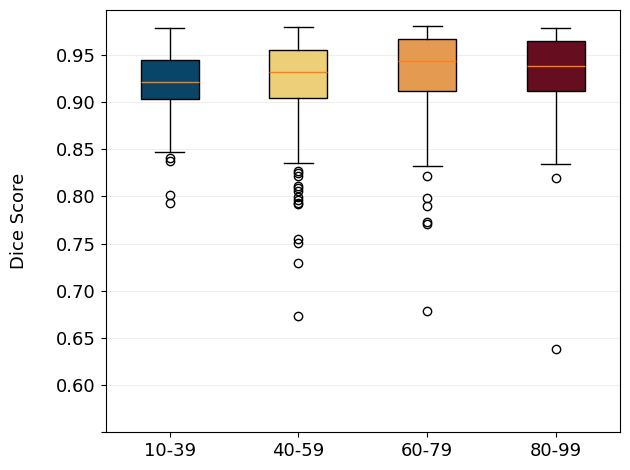

In [33]:
fontsize = 13

fig, ax = plt.subplots()

colors = met_brew(name="Navajo", n=4, brew_type="colorblind")
colors = [colors[3], colors[2], colors[1], colors[0]]

bplot = plt.boxplot([*groups], patch_artist=True)
plt.xticks([1, 2, 3, 4], ['10-39', '40-59', '60-79', '80-99'], fontsize=fontsize)
plt.ylabel('Dice Score', fontsize=fontsize, labelpad=20)
plt.grid(alpha=0.2, axis='y')
plt.yticks(np.arange(0.55, 1, 0.05), ['', '0.60', '0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95'], fontsize=fontsize)

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[c])

plt.tight_layout()

plt.show()

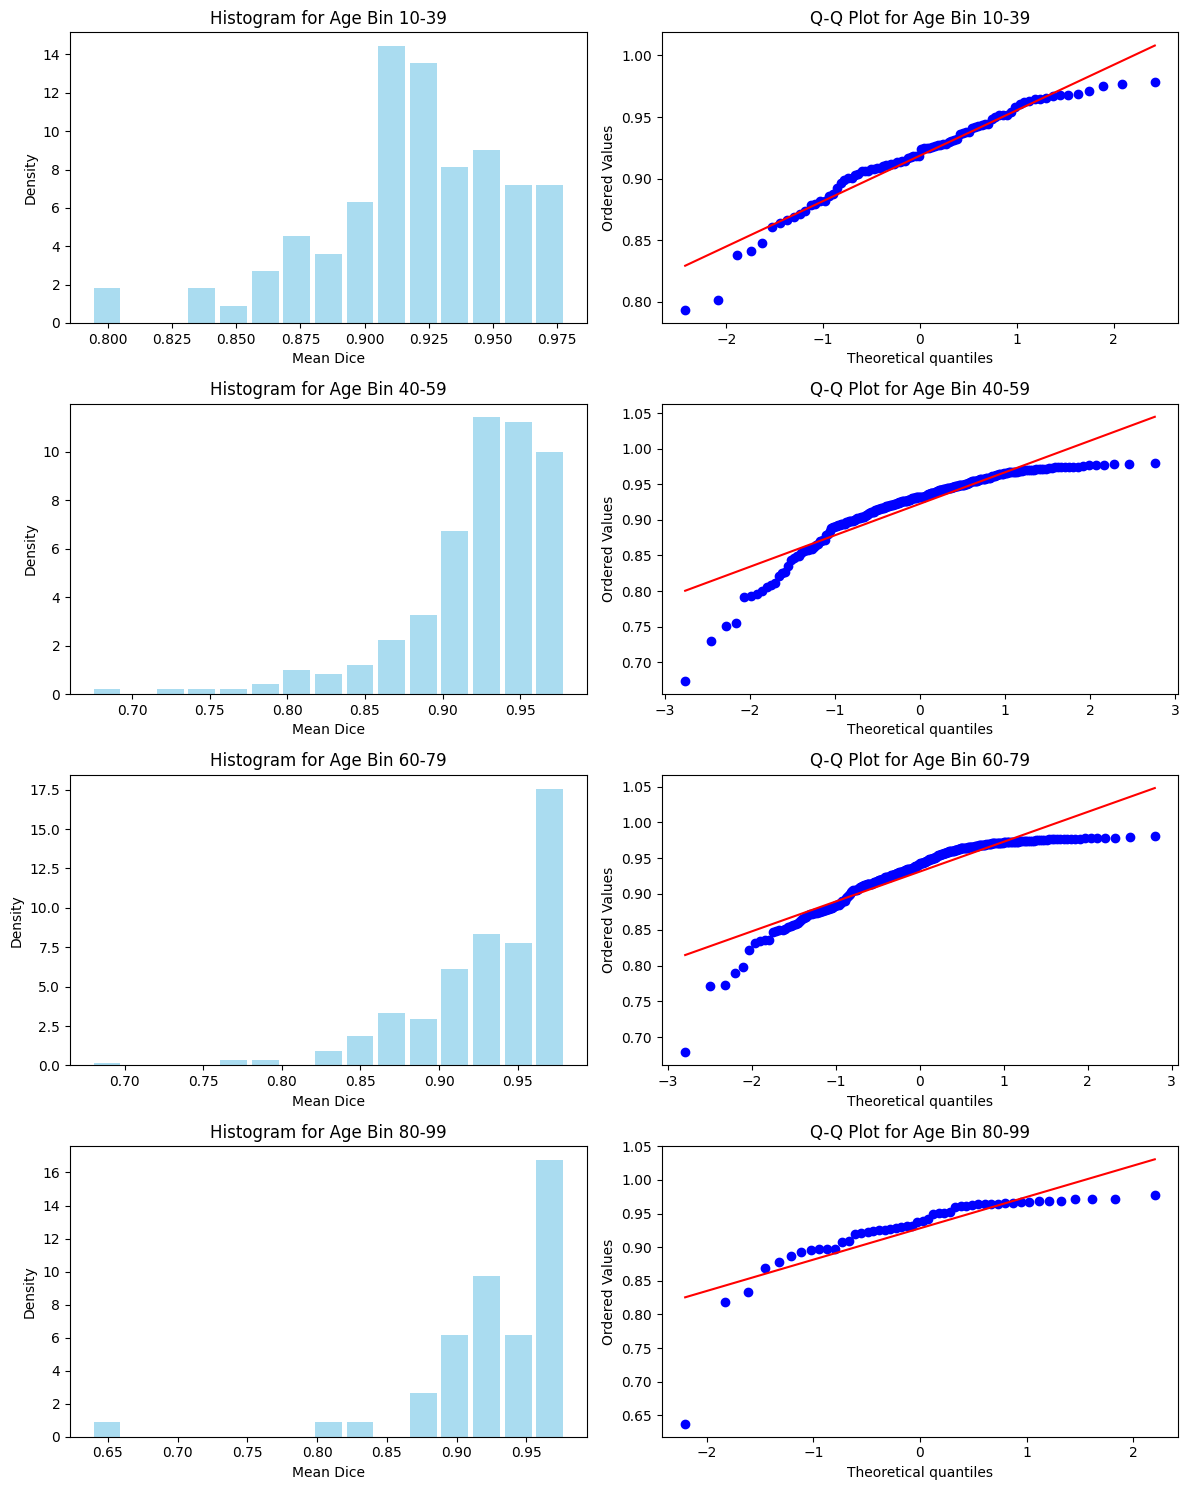

In [62]:
fig, axes = plt.subplots(nrows=len(age_grouped), ncols=2, figsize=(12, 15))
bins = age_grouped['Age Bin']

for i, bin in enumerate(bins):
    # Histogram
    axes[i, 0].hist(groups[i], bins=15, color='skyblue', alpha=0.7, rwidth=0.85, density=True)
    axes[i, 0].set_title(f'Histogram for Age Bin {bin}')
    axes[i, 0].set_xlabel('Mean Dice')
    axes[i, 0].set_ylabel('Density')

    # Q-Q plot
    stats.probplot(groups[i], dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot for Age Bin {bin}')

plt.tight_layout()

plt.show()

In [63]:
for group in groups:
    print(stats.shapiro(group))

ShapiroResult(statistic=0.9489686132859158, pvalue=0.0014462681119666117)
ShapiroResult(statistic=0.8485834470105311, pvalue=1.2805202153712935e-14)
ShapiroResult(statistic=0.8601075375519416, pvalue=6.743515838823513e-15)
ShapiroResult(statistic=0.6908676893763005, pvalue=5.695517313820955e-09)


In [64]:
stats.kruskal(*groups)

KruskalResult(statistic=16.443812693511745, pvalue=0.0009194997212288191)

In [ ]:
sp.posthoc_dunn(data, val_col='mean dice', group_col='age_bin', p_adjust='bonferroni')

### Manufacturer

In [34]:
data = data.replace('ge medical systems', 'ge')

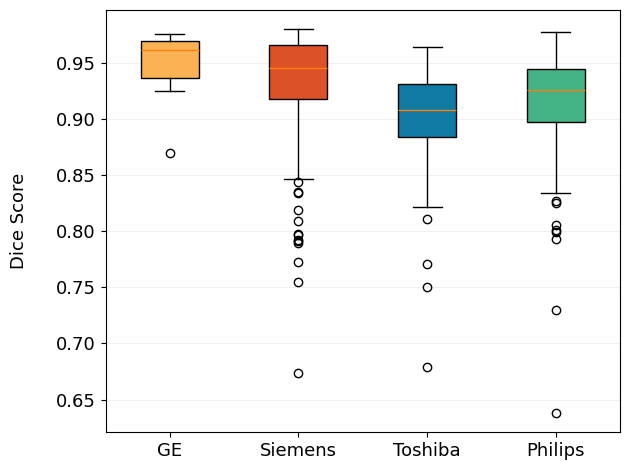

In [11]:
fontsize = 13

fig, ax = plt.subplots()

colors = met_brew(name="Egypt", n=4, brew_type="colorblind")

values = list(data.groupby('manufacturer')['mean dice'])

bplot = plt.boxplot([brand[1] for brand in [values[0], values[2], values[3], values[1]]], patch_artist=True)
plt.xticks([1, 2, 3, 4], ['GE', 'Siemens', 'Toshiba', 'Philips'], fontsize=fontsize)
plt.ylabel('Dice Score', fontsize=fontsize, labelpad=20)
plt.grid(alpha=0.2, axis='y')
plt.yticks(fontsize=fontsize)

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[c-1])

plt.tight_layout()

plt.show()

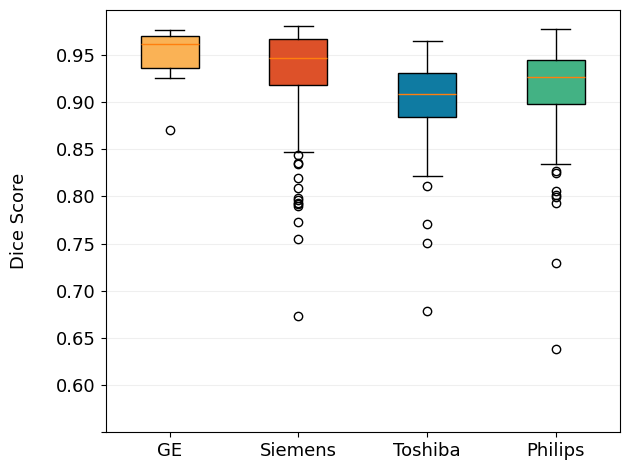

In [36]:
fontsize = 13

fig, ax = plt.subplots()

colors = met_brew(name="Egypt", n=4, brew_type="colorblind")

values = list(data.groupby('manufacturer')['mean dice'])

bplot = plt.boxplot([brand[1] for brand in [values[0], values[2], values[3], values[1]]], patch_artist=True)
plt.xticks([1, 2, 3, 4], ['GE', 'Siemens', 'Toshiba', 'Philips'], fontsize=fontsize)
plt.ylabel('Dice Score', fontsize=fontsize, labelpad=20)
plt.grid(alpha=0.2, axis='y')
plt.yticks(np.arange(0.55, 1, 0.05), ['', '0.60', '0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95'], fontsize=fontsize)

for c, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[c-1])

plt.tight_layout()

plt.show()

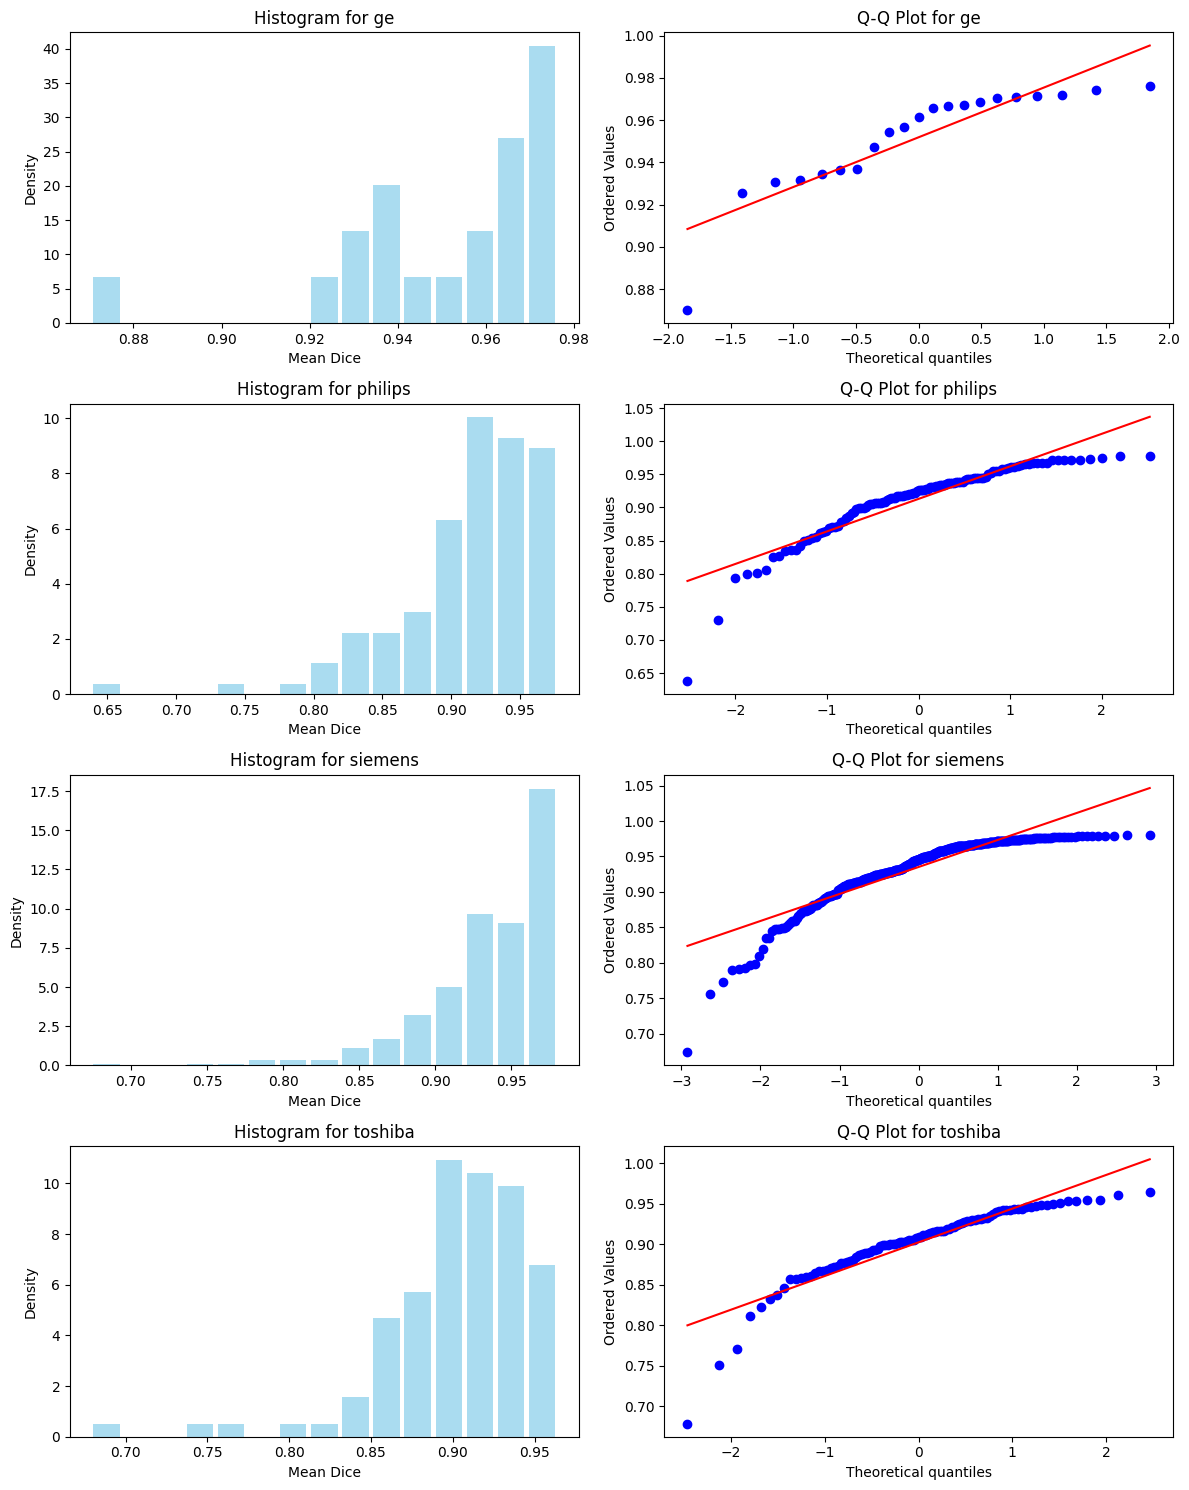

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))

for i, manufacturer in enumerate(['ge', 'philips', 'siemens', 'toshiba']):

    manufacturer_data = data[data['manufacturer'] == manufacturer]['mean dice']
    
    # Histogram
    axes[i, 0].hist(manufacturer_data, bins=15, color='skyblue', alpha=0.7, rwidth=0.85, density=True)
    axes[i, 0].set_title(f'Histogram for {manufacturer}')
    axes[i, 0].set_xlabel('Mean Dice')
    axes[i, 0].set_ylabel('Density')

    # Q-Q plot
    stats.probplot(manufacturer_data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot for {manufacturer}')
    
    plt.tight_layout()


In [18]:
for i, manufacturer in enumerate(['ge', 'philips', 'siemens', 'toshiba']):

    manufacturer_data = data[data['manufacturer'] == manufacturer]['mean dice']
    print(stats.shapiro(manufacturer_data))

ShapiroResult(statistic=0.8056385357469523, pvalue=0.0008011132574015556)
ShapiroResult(statistic=0.8510884854033042, pvalue=1.3725904593713451e-09)
ShapiroResult(statistic=0.8362946655320062, pvalue=6.829477750142375e-20)
ShapiroResult(statistic=0.8535800485885665, pvalue=1.4259261504267158e-08)


In [81]:
stats.kruskal(*[data['mean dice'][data['manufacturer'] == m] for m in ['siemens', 'philips', 'ge', 'toshiba']])

KruskalResult(statistic=82.3731760782382, pvalue=9.503958268223991e-18)

### Dataset Ranking

In [102]:
data = {
    "Anatomical_Structure": ["Spl", "RKid", "LKid", "Gall", "Eso", "Liv", "Sto", "Aor", "IVC", "Pan", "RAG", "LAG"],
    "BTCV_Dice": [95.54, 91.65, 94.17, 71.5, 79.21, 96.81, 93.44, 92.37, 88.14, 83.39, 73.38, 72.05],
    "AMOS_Dice": [96.93, 96.36, 95.89, 87.63, 85.58, 97.63, 92.72, 95.44, 90.72, 86.09, 78.78, 80.05],
    "TotalSeg_Dice": [97.8, 97.06, 96.99, 87.45, 92.19, 98.79, 95.33, 97.77, 95.14, 92.19, 90.27, 90.03]
}

df = pd.DataFrame(data)

df['BTCV_Rank'] = df['BTCV_Dice'].rank(ascending=False)
df['AMOS_Rank'] = df['AMOS_Dice'].rank(ascending=False)
df['TotalSeg_Rank'] = df['TotalSeg_Dice'].rank(ascending=False)

btcv_amos_corr, btcv_amos_p = stats.spearmanr(df['BTCV_Rank'], df['AMOS_Rank'])
btcv_totalseg_corr, btcv_totalseg_p = stats.spearmanr(df['BTCV_Rank'], df['TotalSeg_Rank'])
amos_totalseg_corr, amos_totalseg_p = stats.spearmanr(df['AMOS_Rank'], df['TotalSeg_Rank'])

btcv_totalseg_corr, btcv_totalseg_p, amos_totalseg_corr, amos_totalseg_p, btcv_amos_corr, btcv_amos_p

(0.9422080999150758,
 4.605617330515962e-06,
 0.900176511814775,
 6.588021000587215e-05,
 0.8741258741258742,
 0.00020071307332423193)

In [104]:
comparison_table = df[['Anatomical_Structure', 'BTCV_Rank', 'AMOS_Rank', 'TotalSeg_Rank']].copy()

comparison_table['Average_Rank'] = comparison_table[['BTCV_Rank', 'AMOS_Rank', 'TotalSeg_Rank']].mean(axis=1)
comparison_table.sort_values(by='Average_Rank', inplace=True)

comparison_table.reset_index(drop=True, inplace=True)
comparison_table

,Anatomical_Structure,BTCV_Rank,AMOS_Rank,TotalSeg_Rank,Average_Rank
0,Liv,1.0,1.0,1.0,1.000000
1,Spl,2.0,2.0,2.0,2.000000
2,LKid,3.0,4.0,5.0,4.000000
3,RKid,6.0,3.0,4.0,4.333333
4,Aor,5.0,5.0,3.0,4.333333
5,Sto,4.0,6.0,6.0,5.333333
6,IVC,7.0,7.0,7.0,7.000000
7,Pan,8.0,9.0,8.5,8.500000
8,Eso,9.0,10.0,8.5,9.166667
9,Gall,12.0,8.0,12.0,10.666667
